In [4]:
!pip install anthropic

     -------------------------------------- 869.1/869.1 kB 3.4 MB/s eta 0:00:00


# Data Example

Let's see if we can load an example and get Claude to give some synthetic data for it

In [1]:
import joblib

# Example data
x = joblib.load('example.joblib')

x

In the image, a man and a woman are taking a selfie together in front of a building. The woman is wearing sunglasses and holding a selfie stick, while the man is wearing a white hat and is standing close to the woman. The woman is smiling while taking the picture. The background consists of a white building, and the woman has a black cellphone in her hand. There are various bags visible in the scene, such as a backpack near


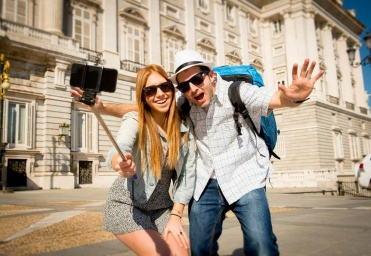

In [2]:
from IPython.display import Image

print(x[0])
display(x[1])

In [5]:
from claude_wrapper import ClaudeOneShot

In [6]:
chat = ClaudeOneShot()

system = "Given a description of an image, make some questions that \
could only be answered by someone that is able to see the image but not the caption. \
Please follow a strict format in your response where you give the questions as a list i.e. [{question 1}, {question 2}] with no need for numbering"
res = chat(system, x[0])

def postproc(res):
    new = res[res.find("[")+1:res.find("]")].split("?,")
    new = [new_i.strip() for new_i in new]
    return new

res = postproc(res)

In [7]:
res

["What color is the man's hat",
 'Is the woman wearing sunglasses or regular glasses',
 'What color is the building in the background',
 'What object is the woman holding to take the selfie',
 "What color is the woman's cellphone?"]

# SAM

Now we will try to incorporate segment anything model and use its outputs for giving further context to claude. First we'll do SAM

In [8]:
from transformers import pipeline
import requests
from PIL import Image

# Example image from HF
img_url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/car.jpg"
raw_image = Image.open(requests.get(img_url, stream=True).raw).convert("RGB")

In [9]:
sam_pipe = pipeline("mask-generation", model = "facebook/sam-vit-huge", device = 'cuda')

config.json:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

C:\Users\Shahbuland\miniconda3\envs\baseml\lib\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Shahbuland\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


model.safetensors:   0%|          | 0.00/2.56G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

In [17]:
res = sam_pipe(x[1], points_per_batch = 32)

In [18]:
masks = res['masks']

In [19]:
import matplotlib.pyplot as plt

def generate_colors(n_colors):
    # Use the 'jet' colormap
    cmap = plt.cm.jet
    # Generate colors from the colormap
    colors = [cmap(i/n_colors)[:3] for i in range(n_colors)]
    # Convert colors to 3-tuples in the range 0-255 (for RGB)
    colors = [(int(r*255), int(g*255), int(b*255)) for r, g, b in colors]
    return colors

In [20]:
import numpy as np
from PIL import Image

# Create a blank image with the same dimensions as the masks and 3 color channels (RGB)
height, width = masks[0].shape
image = np.zeros((height, width, 3), dtype=np.uint8)

# Define a list of colors, one for each mask
colors = generate_colors(len(masks))

# Overlay each mask onto the image with its respective color
for mask, color in zip(masks, colors):
    for c in range(3):  # Iterate over the color channels
        image[:,:,c] = np.where(mask, color[c], image[:,:,c])

# Convert the resulting image to a PIL Image
pil_image = Image.fromarray(image)

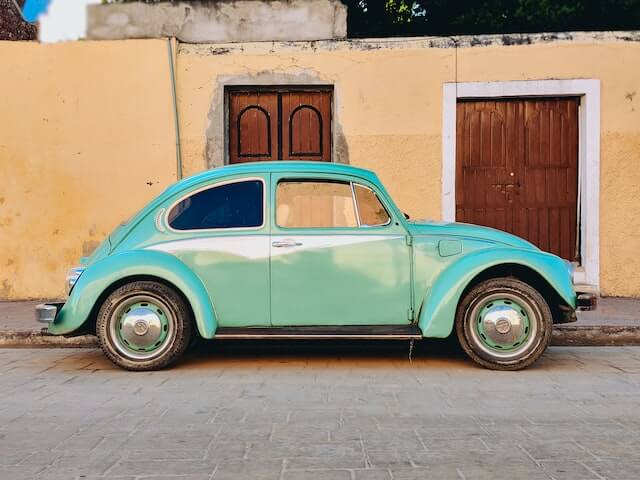

In [21]:
display(raw_image)

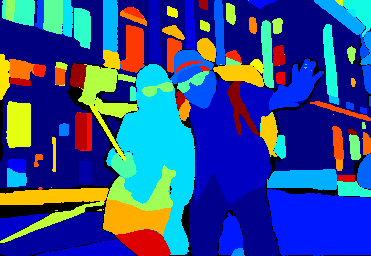

In [22]:
display(pil_image)

# YOLO

In [54]:
from ultralytics import YOLO

# Load a model
model = YOLO("yolov8n.yaml")  # build a new model from scratch
model = YOLO("yolov8n.pt")  # load a pretrained model (recommended for training)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6.23M/6.23M [00:00<00:00, 19.5MB/s]


In [56]:
res = model(x[1])


0: 448x640 2 persons, 1 traffic light, 28.0ms
Speed: 4.0ms preprocess, 28.0ms inference, 4.0ms postprocess per image at shape (1, 3, 448, 640)


In [69]:
print(res[0].boxes.xywh)
print(res[0].boxes.cls)
print(res[0].names)

tensor([[248.1974, 150.7912, 151.7559, 201.2637],
        [140.2776, 159.7103, 103.5045, 190.8880],
        [ 93.8914,  78.3539,  48.2739,  31.6519]], device='cuda:0')
tensor([0., 0., 9.], device='cuda:0')
{0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'd

# DETR

In [24]:
from transformers import pipeline

detr_pipe = pipeline("object-detection", model="facebook/detr-resnet-50", device = 'cuda')

config.json:   0%|          | 0.00/4.59k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


preprocessor_config.json:   0%|          | 0.00/270 [00:00<?, ?B/s]

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


In [25]:
res = detr_pipe(x[1])

In [28]:
def box_to_list(box):
    return [box['xmin'], box['ymin'], box['xmax'], box['ymax']]

def detr_postprocess(output):
    labels = [res['label'] for res in output]
    boxes = [box_to_list(res['box']) for res in output]
    return labels, boxes

# Results from detr are a list of dictionaries. The main things we care about in each dictionary are the 'label' and the 'box'
# Let's extract labels and boxes as arrays of [x, y, x+w,y+h]
def call_detr(img):
    return detr_postprocess(detr_pipe(img))

In [29]:
call_detr(x[1])

(['car', 'person', 'handbag', 'person'],
 [[356, 150, 370, 193],
  [72, 62, 192, 256],
  [230, 81, 280, 161],
  [170, 50, 327, 256]])

# Depth Estimation

In [30]:
depth_pipe = pipeline("depth-estimation", model="Intel/dpt-large", device = 'cuda')

config.json:   0%|          | 0.00/942 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.37G [00:00<?, ?B/s]

Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


preprocessor_config.json:   0%|          | 0.00/285 [00:00<?, ?B/s]

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [31]:
res = depth_pipe(x[1])

In [34]:
res

{'predicted_depth': tensor([[[ 6.3026,  6.2575,  6.2674,  ...,  0.3048,  0.2927,  0.2438],
          [ 6.2564,  6.2532,  6.2658,  ...,  0.2753,  0.2991,  0.2339],
          [ 6.2471,  6.2594,  6.2300,  ...,  0.2724,  0.2779,  0.2362],
          ...,
          [18.8399, 18.9170, 18.9258,  ..., 12.5362, 12.4592, 12.4313],
          [18.9758, 18.9629, 19.0219,  ..., 12.5632, 12.5005, 12.4878],
          [19.0328, 19.0238, 19.0420,  ..., 12.6673, 12.5997, 12.5125]]]),
 'depth': <PIL.Image.Image image mode=L size=371x256>}

# Putting It Together

In the end the only things I can see as actually useful for synthetic data are the bounding boxes/classifications from DETR and the depth map from depth estimation.